In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:59437" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:59455, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:59454, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:59460, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

In [5]:
#changing classes to numeric values for ingestion into model
train_y = train_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})
test_y = test_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})

# Tensorflow - 3 layers, selu/softmax, adamax

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy

In [7]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=371, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

In [8]:
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
    
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=1)

with joblib.parallel_backend('dask'):
    model.fit(train_X, train_y)

Epoch 1/50
4455/4455 [==============================] - 41s 1ms/step - loss: 0.7129 - accuracy: 0.7069
Epoch 2/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.6200 - accuracy: 0.7476
Epoch 3/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.6059 - accuracy: 0.7531
Epoch 4/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5939 - accuracy: 0.7549
Epoch 5/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5902 - accuracy: 0.7560
Epoch 6/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5943 - accuracy: 0.7520
Epoch 7/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5811 - accuracy: 0.7585
Epoch 8/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5815 - accuracy: 0.7574
Epoch 9/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.5786 - accuracy: 0.7605
Epoch 10/50
4455/4455 [==============================] - 6s 1ms/step - loss: 0.57

In [9]:
model.score(test_X, test_y)

1485/1485 [==============================] - 3s 1ms/step - loss: 0.5545 - accuracy: 0.7698: 0s - l


0.7697643041610718

In [10]:
#Create dataframe to store metrics and parameters
tf_deets = pd.DataFrame(model.get_params(), index=['TF'])
tf_deets.insert(0, value=model.score(test_X, test_y), column='Accuracy')
tf_deets

1485/1485 [==============================] - 2s 1ms/step - loss: 0.5545 - accuracy: 0.7698


,Accuracy,epochs,batch_size,verbose,build_fn
TF,0.769764,50,10,1,<function create_model at 0x0000018DD6B97280>


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1485/1485 [==============================] - 2s 937us/step


<Figure size 2880x576 with 0 Axes>

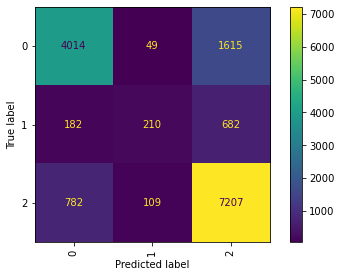

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      5678
           1       0.57      0.20      0.29      1074
           2       0.76      0.89      0.82      8098

    accuracy                           0.77     14850
   macro avg       0.71      0.60      0.62     14850
weighted avg       0.76      0.77      0.76     14850



In [11]:
#Visualize metrics by class using Confusion martix and Classification Report
y_pred = model.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=model.classes_))

# Tensorflow - 5 layers, relu/softmax, adam, class_weight

In [17]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=371, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
cw_dict={0:1, 1:1.25, 2:1}
    
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=1, class_weight=cw_dict)

with joblib.parallel_backend('dask'):
    model.fit(train_X, train_y)

Epoch 1/50
4455/4455 [==============================] - 9s 2ms/step - loss: 0.7417 - accuracy: 0.7150
Epoch 2/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.6101 - accuracy: 0.7623
Epoch 3/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5867 - accuracy: 0.7679
Epoch 4/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5720 - accuracy: 0.7790
Epoch 5/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5597 - accuracy: 0.7845
Epoch 6/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5554 - accuracy: 0.7828
Epoch 7/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5382 - accuracy: 0.7896: 0s - loss: 0.5379 - accura
Epoch 8/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5337 - accuracy: 0.7952
Epoch 9/50
4455/4455 [==============================] - 7s 2ms/step - loss: 0.5360 - accuracy: 0.7939
Epoch 10/50
4455/4455 [==============================]

In [19]:
model.score(test_X, test_y)

1485/1485 [==============================] - 3s 1ms/step - loss: 0.5794 - accuracy: 0.7716


0.7715824842453003

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1485/1485 [==============================] - 2s 1ms/step


<Figure size 2880x576 with 0 Axes>

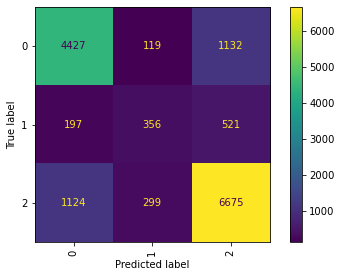

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      5678
           1       0.46      0.33      0.39      1074
           2       0.80      0.82      0.81      8098

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.76      0.77      0.77     14850



In [20]:
#Visualize metrics by class using Confusion martix and Classification Report
y_pred = model.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=model.classes_))

In [21]:
#Create dataframe to store metrics and parameters
deets = pd.DataFrame(model.get_params(), index=['TF_weight'])
deets.insert(0, value=model.score(test_X, test_y), column='Accuracy')
tf_deets=pd.concat([tf_deets, deets])
tf_deets

1485/1485 [==============================] - 2s 1ms/step - loss: 0.5794 - accuracy: 0.7716: 0s - loss: 0.5770 - 


,Accuracy,epochs,batch_size,verbose,class_weight,build_fn
TF_weight,0.771582,50,10,1,NaN,<function create_model at 0x0000018DDC2D8790>


### Cross Validation

In [22]:
#Confirm generalizability via 5-fold cross validation
print(cross_val_score(model, train_X, train_y, cv=5))

Epoch 1/50
3564/3564 [==============================] - 9s 2ms/step - loss: 0.7372 - accuracy: 0.7041
Epoch 2/50
3564/3564 [==============================] - 7s 2ms/step - loss: 0.6203 - accuracy: 0.7565: 0s - loss:
Epoch 3/50
3564/3564 [==============================] - 7s 2ms/step - loss: 0.5920 - accuracy: 0.7688
Epoch 4/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5784 - accuracy: 0.7755
Epoch 5/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5673 - accuracy: 0.7781
Epoch 6/50
3564/3564 [==============================] - 7s 2ms/step - loss: 0.5531 - accuracy: 0.7844: 0s - loss: 0.5530 - accuracy: 
Epoch 7/50
3564/3564 [==============================] - 7s 2ms/step - loss: 0.5585 - accuracy: 0.7817
Epoch 8/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5426 - accuracy: 0.7897: 1s - loss: 0.5413 - ac - E - ETA: 0s - loss: 0.5424 
Epoch 9/50
3564/3564 [==============================] - ETA: 0s - loss: 0.5354 - accur

3564/3564 [==============================] - 6s 2ms/step - loss: 0.4926 - accuracy: 0.8059: 4s
Epoch 26/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4860 - accuracy: 0.8092
Epoch 27/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4932 - accuracy: 0.8075: 1s - loss: 0.4923 -  - ETA: 
Epoch 28/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4858 - accuracy: 0.8096
Epoch 29/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4914 - accuracy: 0.8078
Epoch 30/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4826 - accuracy: 0.8096
Epoch 31/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4831 - accuracy: 0.8117
Epoch 32/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4857 - accuracy: 0.8119
Epoch 33/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4789 - accuracy: 0.8133
Epoch 34/50
3564/3564 [============================

3564/3564 [==============================] - 8s 2ms/step - loss: 0.7417 - accuracy: 0.6969
Epoch 2/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.6179 - accuracy: 0.7595
Epoch 3/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5959 - accuracy: 0.7646
Epoch 4/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5733 - accuracy: 0.7734
Epoch 5/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5639 - accuracy: 0.7786: 0s - loss:
Epoch 6/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5469 - accuracy: 0.7882
Epoch 7/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5388 - accuracy: 0.7864
Epoch 8/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5256 - accuracy: 0.7950
Epoch 9/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.5185 - accuracy: 0.7993
Epoch 10/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.52

3564/3564 [==============================] - 6s 2ms/step - loss: 0.4757 - accuracy: 0.8193
Epoch 29/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4765 - accuracy: 0.8169
Epoch 30/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4697 - accuracy: 0.8222
Epoch 31/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4757 - accuracy: 0.8177
Epoch 32/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4751 - accuracy: 0.8186: 1s - los
Epoch 33/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4707 - accuracy: 0.8191
Epoch 34/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4666 - accuracy: 0.8203
Epoch 35/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4679 - accuracy: 0.8240
Epoch 36/50
3564/3564 [==============================] - 6s 2ms/step - loss: 0.4708 - accuracy: 0.8199
Epoch 37/50
3564/3564 [==============================] - 6s 2ms/step - loss

In [23]:
#Output for comparision
tf_deets.to_pickle('Data/scores/TF.pkl')